# 2.3.1

In [ ]:
import torch
from torch import nn

vocabulary_size = 100
d_model = 512

embedding = nn.Embedding(vocabulary_size, d_model)
tokens = torch.Tensor([1, 2, 3]).long()

print(embedding(tokens).shape)

# 2.3.2

In [ ]:
from llm_from_scratch.transformer.utils import sinusoidal_position_encoding

In [ ]:
d_model = 128
sequence_length = 100
pe = sinusoidal_position_encoding(d_model=d_model, sequence_length=sequence_length)[0]

In [ ]:
import matplotlib.pyplot as plt
import japanize_matplotlib

fig, ax = plt.subplots(figsize=(10, 6))
cax = ax.matshow(pe, cmap="gray")
fig.colorbar(cax)
ax.set_xlabel("次元")
ax.set_ylabel("位置")
fig.savefig("sinusoidal_position_encoding.png", bbox_inches="tight")
plt.show()

In [ ]:
import torch

dotprod = torch.matmul(pe, pe.transpose(0, 1))

fig, ax = plt.subplots(figsize=(10, 10))

cax = ax.matshow(dotprod, cmap="gray")
fig.colorbar(cax)
ax.set_title("位置エンコーディングの内積")
ax.set_xlabel("位置")
ax.set_ylabel("位置")
fig.savefig("sinusoidal_position_encoding_dotprod.png", bbox_inches="tight")
plt.show()

In [ ]:
import numpy as np


dots = np.zeros(sequence_length)
for pos in range(sequence_length):
    total = 0
    for d in range(d_model // 2):
        total += np.cos(pos / (10000 ** (2 * d / d_model)))
    dots[pos] = total

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(dots)
ax[1].plot(dots)
for i in range(sequence_length):
    ax[1].plot(dotprod[i, i:])
ax[0].set_xlabel("位置の差")
ax[1].set_xlabel("位置の差")
ax[0].set_title("理論値")
ax[1].set_title("実測値")
ax[0].set_ylabel("内積")
ax[1].set_ylabel("内積")
plt.show()

# 2.3.3

In [3]:
import torch
from torch import nn

d_model = 512
d_ff = d_model * 4

feed_forward = nn.Sequential(
    nn.Linear(d_model, d_ff),
    nn.ReLU(),
    nn.Linear(d_ff, d_model),
)

x = torch.randn(1, 10, d_model)

print("input shape:", x.shape)
print("output shape:", feed_forward(x).shape)

input shape: torch.Size([1, 10, 512])
output shape: torch.Size([1, 10, 512])


# 2.3.4

In [ ]:
import torch
from torch import nn


class FNN(nn.Module):
    def __init__(self, d_model, d_ff):
        super(FNN, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        return self.linear2(torch.relu(self.linear1(x)))


class SkipConnection(nn.Module):
    def __init__(self, d_model, d_ff):
        super(SkipConnection, self).__init__()
        self.sublayer = FNN(d_model, d_ff)

    def forward(self, x):
        return x + self.sublayer(x)

In [ ]:
# 恒等関数の学習
from tqdm.auto import tqdm

n_epochs = 100
N = 10000
data = torch.randn(N, 10)

model1 = FNN(10, 128)
model2 = SkipConnection(10, 128)

criterion = nn.MSELoss()
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.001)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.001)

pbar = tqdm(total=n_epochs, position=0)
loss1_history = []
loss2_history = []
for epoch in range(n_epochs):
    pbar.update(1)
    optimizer1.zero_grad()
    optimizer2.zero_grad()

    loss1 = criterion(model1(data), data)
    loss2 = criterion(model2(data), data)

    loss1.backward()
    loss2.backward()

    optimizer1.step()
    optimizer2.step()

    loss1_history.append(loss1.item())
    loss2_history.append(loss2.item())

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: {loss1.item()}, {loss2.item()}")

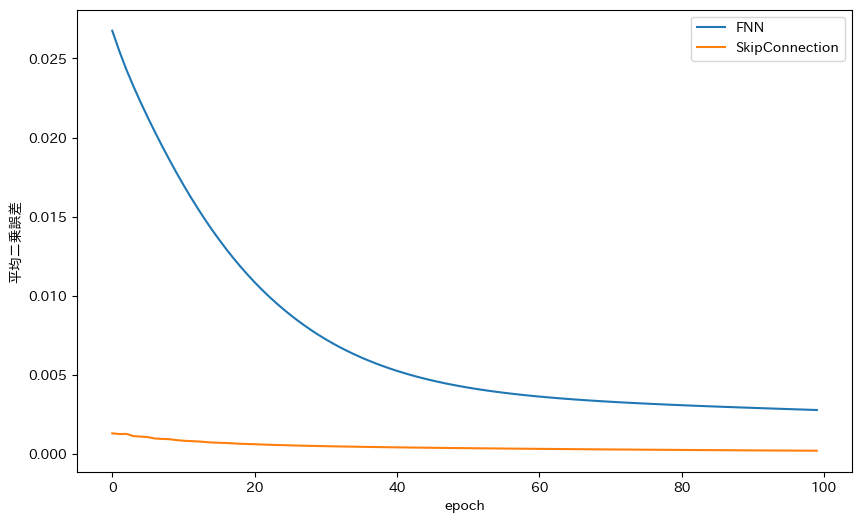

In [13]:
import matplotlib.pyplot as plt
import japanize_matplotlib

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(loss1_history, label="FNN")
ax.plot(loss2_history, label="SkipConnection")
ax.set_xlabel("epoch")
ax.set_ylabel("平均二乗誤差")
ax.legend()

fig.savefig("skip_connection_loss.png", bbox_inches="tight")
plt.show()

# 2.3.5

In [29]:
import torch

batch, sentence_length, embedding_dim = 20, 5, 10

# 埋め込みベクトルを擬似的に生成
embedding = torch.randn(batch, sentence_length, embedding_dim)
mean = embedding.mean(axis=[-1], keepdim=True)
std = embedding.std(axis=[-1], keepdim=True, unbiased=False)

# 正規化
eps = 1e-8
normalized_embedding = (embedding - mean) / std.add(eps)

# 3番目の文の2番目の単語位置の特徴ベクトルを取得
feature_vector = normalized_embedding[3, 2, :]
print(feature_vector.mean(), feature_vector.std(unbiased=False))

tensor(-1.1921e-08) tensor(1.)


tensor(1.7881e-08) tensor(1.0000)
